<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Случайный-лес" data-toc-modified-id="Модель-Случайный-лес-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель Случайный лес</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [2]:
state = 12345

In [3]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df_taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


Выполним ресемплирование данных по одному часу:

In [5]:
df_taxi = df_taxi.resample('1H').sum()

In [6]:
df_taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [7]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Функция для создания признаков:

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(df_taxi, 24, 40)

In [10]:
df_taxi = df_taxi.dropna()

In [11]:
df_taxi.head(3)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 16:00:00,82,3,2,4,59.0,44.0,45.0,36.0,91.0,54.0,...,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,54.55
2018-03-02 17:00:00,83,3,2,4,82.0,59.0,44.0,45.0,36.0,91.0,...,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,53.50
2018-03-02 18:00:00,89,3,2,4,83.0,82.0,59.0,44.0,45.0,36.0,...,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,53.45


Разделим данные на выборки, где тестовая выборка составляет 10% от исходных данных

In [12]:
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)

In [13]:
train.tail(3) #проверка

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 15:00:00,175,8,13,0,102.0,119.0,92.0,144.0,156.0,137.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,126.775
2018-08-13 16:00:00,144,8,13,0,175.0,102.0,119.0,92.0,144.0,156.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,127.275
2018-08-13 17:00:00,152,8,13,0,144.0,175.0,102.0,119.0,92.0,144.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,126.525


In [14]:
test.head(3) 

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 18:00:00,104,8,13,0,152.0,144.0,175.0,102.0,119.0,92.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,125.900
2018-08-13 19:00:00,91,8,13,0,104.0,152.0,144.0,175.0,102.0,119.0,...,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,124.575
2018-08-13 20:00:00,82,8,13,0,91.0,104.0,152.0,144.0,175.0,102.0,...,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,123.450


In [15]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Краткие выводы о проделанной работе:

- импортировали библиотеки
- прочли данные - исторические данные о заказах такси в аэропортах
- выполнили ресемплирование данных по одному часу
- сгенерировали новые признаки
- разделили данные на выборки

## Анализ

Проверим, в хронологическом ли порядке расположены даты и время. Если порядок соблюдён, атрибут `is_monotonic` вернёт True, если нет — False.

In [16]:
df_taxi.index.is_monotonic

True

Изучим тренд и сезонность в целевом признаке: 

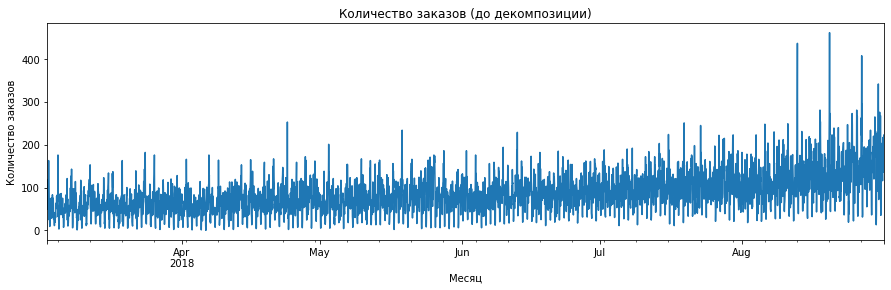

In [17]:
df_taxi['num_orders'].plot(figsize=(15, 4))
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Количество заказов (до декомпозиции)');

По графику с исходными данными о заказах заметен рост их количества с течением времени. Посмотрим на графики после декомпозиции временного ряда:

In [18]:
decomposed = seasonal_decompose(df_taxi['num_orders'])

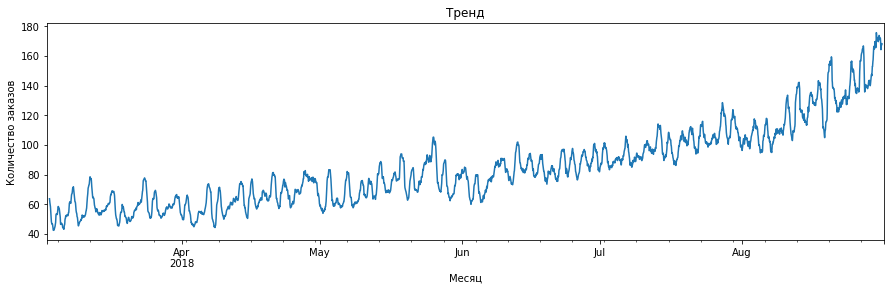

In [19]:
plt.figure(figsize=(15, 4))
decomposed.trend.plot()
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Тренд');

Наблюдаем растущий тренд в период с марта по конец августа.

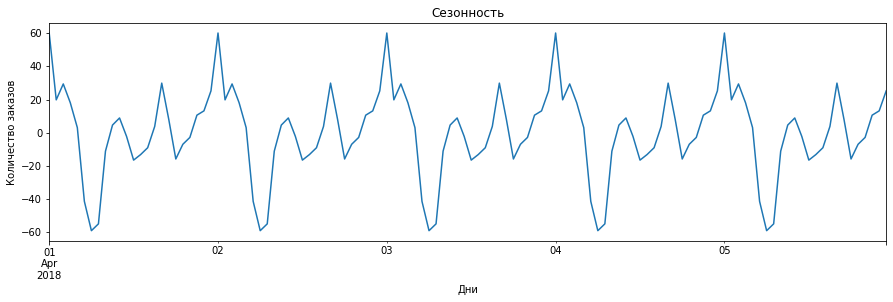

In [20]:
plt.figure(figsize=(15, 4))
decomposed.seasonal['2018-04-01':'2018-04-05'].plot()
plt.ylabel('Количество заказов')
plt.xlabel('Дни')
plt.title('Сезонность');

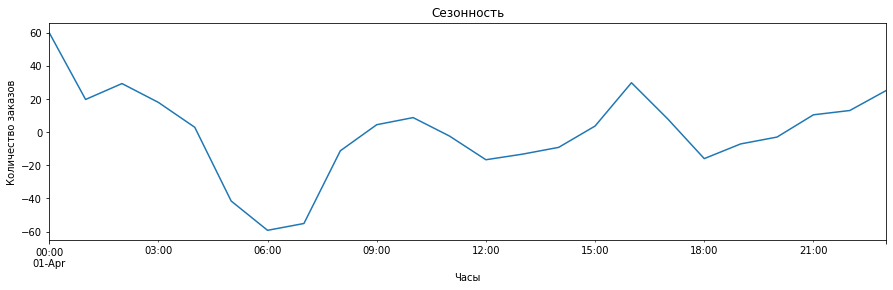

In [21]:
plt.figure(figsize=(15, 4))
decomposed.seasonal['2018-04-01':'2018-04-01'].plot()
plt.ylabel('Количество заказов')
plt.xlabel('Часы')
plt.title('Сезонность');

На графике сезонности заметна цикличность количества заказов - минимальный спрос каждый день приходится на 6 утра, а максимальный на 12 ночи.

Изучим график скользящей средней по количеству заказов `num_orders`:

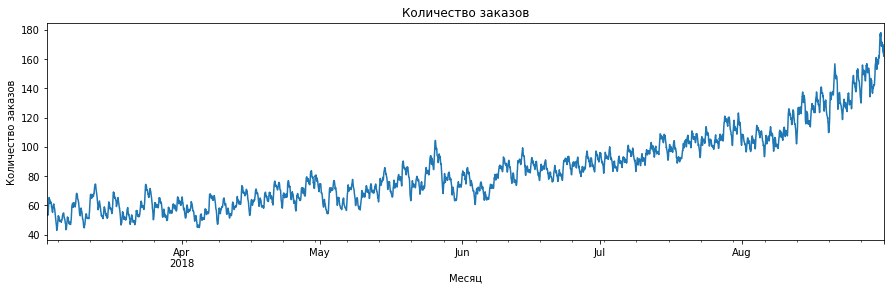

In [22]:
df_taxi['rolling_mean'].plot(figsize=(15, 4))
plt.ylabel('Количество заказов')
plt.xlabel('Месяц')
plt.title('Количество заказов');

График выглядит идентично графику тренда, заметен рост с уровня 60 примерно в 3 раза.

Выводы:

- изучили графики тренда и сезонности в целевом признаке
- определили растущий тренд и закономерности по дням
- график сезонности стационарен
- изучили график скользящей средней - график нестационарен

## Обучение

Обучим разные модели и подберем гиперпараметры:

In [23]:
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

### Модель Случайный лес

In [24]:
rfr = RandomForestRegressor(random_state=state)

parametrs = {'n_estimators': range (120, 131, 10),  # параметры были уменьшены для ускорения кода на время проверки
              'max_depth': range (20, 31, 5)}

In [25]:
tscv = TimeSeriesSplit(n_splits=2)

grid = GridSearchCV(rfr, parametrs, cv=tscv, scoring=scorer)
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 30, 'n_estimators': 130}

In [26]:
grid.best_score_ * -1

28.273513865912758

### Модель LightGBM

In [27]:
lgr = LGBMRegressor(random_state=state)

parametrs = {'n_estimators': range (140, 151, 10),
              'max_depth': range (10, 21, 5),
              'num_leaves': range (10, 21, 5)}

In [28]:
tscv = TimeSeriesSplit(n_splits=2)

grid = GridSearchCV(lgr, parametrs, cv=tscv, scoring=scorer)
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 15, 'n_estimators': 150, 'num_leaves': 15}

In [29]:
grid.best_score_ * -1

27.944591348672354

Выводы:

- подобрали гиперпараметры для моделей Случайный лес и LGBMRegressor
- протестировали результаты на валидационной выборке
 - для модели `RandomForestRegressor` RMSE равен 28.27
 - для модели `LGBMRegressor` RMSE равен 27.94
 
Выбираем модель с наилучшим результатом - `LGBMRegressor`.

## Тестирование

In [30]:
model_lgr = LGBMRegressor(num_leaves=15, max_depth=15 , n_estimators=150, random_state=state)

In [31]:
model_lgr.fit(features_train, target_train)

LGBMRegressor(max_depth=15, n_estimators=150, num_leaves=15, random_state=12345)

In [32]:
predictions = model_lgr.predict(features_test)

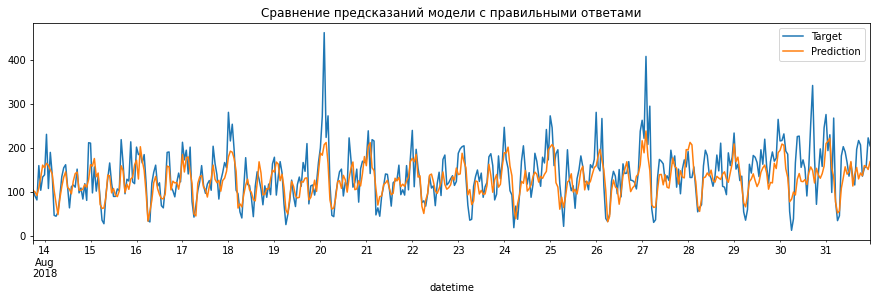

In [33]:
pd.DataFrame({'Target': target_test, 'Prediction': predictions}).plot(
    figsize=(15, 4), title='Сравнение предсказаний модели с правильными ответами');

Графики имеют схожий вид, заметно, что предсказание совпадает со многими средними значениями, но
нестандартно высокие/низкие значения не угадывает.

In [34]:
print('RMSE:', mean_squared_error(target_test, predictions)**0.5)

RMSE: 42.52577844870991


Значение метрики RMSE на тестовой выборке меньше 48 и равно 42,5.